In [1]:
from scipy.spatial import KDTree, cKDTree
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from cooltools.dotfinder import clust_2D_pixels

In [3]:
# minimal subset of columns to handle:
must_columns = ["chrom1",
                "start1",
                "end1",
                "chrom2",
                "start2",
                "end2"]

# HiCCUPs to cooltools BEDPE renamer, just in case:
hiccups_to_cooltools = {'chr1': "chrom1",
                    'x1': "start1",
                    'x2': "end1",
                    'chr2': "chrom2",
                    'y1': "start2",
                    'y2': "end2",
                    'color': "color",
                    'o': "obs.raw",
                    'e_bl': "la_exp.lowleft.value",
                    'e_donut': "la_exp.donut.value",
                    'e_h': "la_exp.horizontal.value",
                    'e_v': "la_exp.vertical.value",
                    'fdr_bl': "la_exp.lowleft.qval",
                    'fdr_donut': "la_exp.donut.qval",
                    'fdr_h': "la_exp.horizontal.qval",
                    'fdr_v': "la_exp.vertical.qval",
                    'num_collapsed': "c_size",
                    'centroid1': "cstart1",
                    'centroid2': "cstart2",
                    'radius': "radius"}

def check_chr_prefix(df, columns=['chrom1','chrom2']):
    """
    Function that checks if chromosome
    labels present in a DataFrame contain
    a commonly used 'chr' prefix.
    Returns a description of the label
    situation: 'all', 'none' or 'some'.

    Parameters                                                                   
    ----------                                                                   
    df : pd.DataFrame
        DataFrame with columns containing
        chromosome labels.
    columns : iterable
        A list of column labels that contain
        chromosome labels and needs to be fixed.
        ['chrom1',chrom2] by default.

    Returns
    -------
    str, description of the label situation.

    """
    num_labels, num_prefixed_labels = 0,0
    for col in columns:
        # accumulate number of prefixed labels per column:
        num_prefixed_labels += df[col].str.startswith("chr").sum()
        # accumulate total number of labels:
        num_labels += len(df)
    # return the label situation description:
    if num_prefixed_labels == 0:
        return 'none'
    elif num_prefixed_labels < num_labels:
        return 'some'
    elif num_prefixed_labels == num_labels:
        return 'all'
    else:
        raise("Should have never happened: 'check_chr_prefix' !")

        
def read_validate_dots_list(dots_path,return_chroms=False):
    # load dots lists ...
    dots = pd.read_table(dots_path)
    # check if 'must_columns' are present:
    if pd.Series(must_columns).isin(dots.columns).all():
        pass
    else:
        print("{} isn't in ct format, trying conversion...".format(dots_path))
        try:
            dots = dots.rename(columns=hiccups_to_cooltools)
        except KeyError as e:
            print("conversion didn't work for {} !".format(dots_path))
            raise e
    # just in case:
    dots["chrom1"] = dots["chrom1"].astype(str)
    dots["chrom2"] = dots["chrom2"].astype(str)
    # consider checking if chrom1/2 columns refer
    # to the same chroms.
    # now check chromosome labels and
    # try to fix them as needed:
    prefix_status = check_chr_prefix(dots, columns=['chrom1','chrom2'])
    if prefix_status == 'all':
        pass
    elif prefix_status == 'none':
        # add 'chr' prefix
        dots["chrom1"] = 'chr'+dots["chrom1"]
        dots["chrom2"] = 'chr'+dots["chrom2"]
    elif prefix_status == 'some':
        raise("Provided chrom labels are messed up!")
    # returning both full DataFrame and a subset
    # with must_columns only
    if return_chroms:
        return dots, dots[must_columns].copy(), dots['chrom1'].unique()
    else:
        return dots, dots[must_columns].copy()

# def read_validate_dots_list(dots_path):
#     # load dots lists ...
#     try:
#         dots = pd.read_table(dots_path)
#         dots_must = dots[must_columns].copy()
#     except KeyError as exc_one:
#         print("Seems like {} is not in cooltools format, trying conversion ...".format(dots_path))
#         try:
#             dots = dots.rename(columns=hiccups_to_cooltools)
#             dots_must = dots[must_columns].copy()
#         except KeyError as exc_two:
#             print("Seems like conversion didn't work for {}".format(dots_path))
#             raise exc_two
#     # returning both full DataFrame and a subset
#     # with must_columns only ...
#     return dots, dots_must


In [7]:
f1 = "final_cloops4mb.10kb.KR.txt"
# f1 = "cloops4mb.10kb.KR.txt"
f1 = "final_diag_cloops4mb.10kb.KR.txt"
# f1="../rao_combined_hic/final_diag_cloops.combined.50000000.txt"
f2 = "Rao2014_GM12878_primary_HiCCUPS_looplist.txt"
# f2 = "../rao_combined_hic/Rao2014_GM12878_primary_and_replicate_HiCCUPS_looplist.txt"

d1f,d1,c1 = read_validate_dots_list(f1,return_chroms=True)
# d1f,d1,c1 = centroids, centroids[must_columns].copy(), centroids['chrom1'].unique()
# d1f,d1,c1 = filtered_centr, filtered_centr[must_columns].copy(), filtered_centr['chrom1'].unique()
d2f,d2,c2 = read_validate_dots_list(f2,return_chroms=True)
# d2f,d2 = dnm2, dnm2[must_columns].copy()

commonc = np.intersect1d(c1,c2,assume_unique=True)


def get_venn(tin,tref,dist_threshold=50000,dist_ratio=0.2):
    """A Function that returns indices of
    2D peaks from 'tin' that have a match in
    'tref', and indices of non-matching ones."""
    padding = 1000
    rad = lambda dist: dist_ratio*dist+padding \
                        if (dist < dist_threshold) \
                            else dist_threshold+padding
    
    
    matching = []
    nonmatching = []
    idx = 0
    for peak in tin.data:
        # how far is this peak from diagonal:
        dist = np.abs(peak[0]-peak[1])
        r = rad(dist)
        # calculate # of neighbours of a peak
        # in the 'tref'-tree:
        nneighbours= len(tref.query_ball_point(peak,r))
        # store the results either in matching or
        # nonmatching lists:
        if nneighbours > 0:
            matching.append(idx)
        elif nneighbours == 0:
            nonmatching.append(idx)
        else:
            raise("Major bug in 'get_venn'!")
        # index increment:
        idx += 1
    return matching, nonmatching


t2_ref_msg = ""
t1_ref_msg = ""

m1all = pd.Index([],dtype=int)
nm1all = pd.Index([],dtype=int)
m2all = pd.Index([],dtype=int)
nm2all = pd.Index([],dtype=int)
all_match = 0
for chrom in commonc:
    non_matching = []
    d1c = d1[d1['chrom1']==chrom]
    d2c = d2[d2['chrom1']==chrom]
    t1 = cKDTree(d1c[['start1','start2']].values)
    t2 = cKDTree(d2c[['start1','start2']].values)
    m1,nm1 = get_venn(t1,t2)
    m2,nm2 = get_venn(t2,t1)
    print("{}:\t{}\tt1-s not in t2, {}\tare; {}\tt2-s are in t1, {}\tare not"\
          .format(chrom,len(nm1),len(m1),len(m2),len(nm2)))
    assert len(m1+nm1) == len(d1c)
    assert len(m2+nm2) == len(d2c)
    m1all = m1all.append(d1c.index[m1])
    nm1all = nm1all.append(d1c.index[nm1])
    m2all = m2all.append(d2c.index[m2])
    nm2all = nm2all.append(d2c.index[nm2])
print("{}:\t{}\tt1-s not in t2, {}\tare; {}\tt2-s are in t1, {}\tare not"\
      .format("ALL",(nm1all).size,(m1all).size,len(m2all),len(nm2all)))
    

# assign diags:    
d1f['diag'] = (d1f['start1']-d1f['start2']).abs()
d2f['diag'] = (d2f['start1']-d2f['start2']).abs()


Rao2014_GM12878_primary_HiCCUPS_looplist.txt isn't in ct format, trying conversion...
chr1:	12	t1-s not in t2, 715	are; 725	t2-s are in t1, 62	are not
chr10:	3	t1-s not in t2, 345	are; 353	t2-s are in t1, 17	are not
chr11:	4	t1-s not in t2, 417	are; 425	t2-s are in t1, 12	are not
chr12:	2	t1-s not in t2, 406	are; 411	t2-s are in t1, 23	are not
chr13:	9	t1-s not in t2, 192	are; 195	t2-s are in t1, 14	are not
chr14:	9	t1-s not in t2, 251	are; 259	t2-s are in t1, 17	are not
chr15:	5	t1-s not in t2, 235	are; 239	t2-s are in t1, 9	are not
chr16:	6	t1-s not in t2, 201	are; 205	t2-s are in t1, 8	are not
chr17:	12	t1-s not in t2, 282	are; 289	t2-s are in t1, 17	are not
chr18:	3	t1-s not in t2, 169	are; 174	t2-s are in t1, 8	are not
chr19:	9	t1-s not in t2, 182	are; 184	t2-s are in t1, 18	are not
chr2:	7	t1-s not in t2, 552	are; 560	t2-s are in t1, 39	are not
chr20:	2	t1-s not in t2, 191	are; 196	t2-s are in t1, 18	are not
chr21:	1	t1-s not in t2, 78	are; 78	t2-s are in t1, 4	are not
chr22:	8	t

In [9]:
len(d2f)

8054

### Define non-overlaping sets

Using indices of peaks from `d1f` that have no matches in `d2f` and vice-versa, get those peaks!

In [10]:

# nonmatching  in D1: stuff that we "overcall" ...
dnm1 = d1f.loc[nm1all]
print(dnm1.shape)

# nonmatching in D2: stuff that we "undercall" ...
dnm2 = d2f.loc[nm2all]
print(dnm2.shape)

(157, 26)
(455, 21)


### Define exact overlap between two sets ...

simply merge `d1f` and `d2f` on chromosomes and start-positions 

In [11]:
mrg = d1f.loc[m1all].merge(d2f.loc[m2all],
                     how='inner',
                     on=['chrom1','chrom2','start1','start2','end1','end2','diag'],
                     sort=True,
                     suffixes=('_x', '_y'),
                     copy=True, indicator=False, validate=None)

In [12]:
cls = ['chrom1', 'start1',
#        'end1',
#        'weight1',
#        'chrom2',
#        'start2',
#        'end2',
#        'weight2',
       'diag',
       'exp.raw', 'obs.raw_x',
       'la_exp.donut.value_x',
       'la_exp.donut.value_y',
       'la_exp.donut.qval_x',
       'la_exp.donut.qval_y',
       'la_exp.donut.nnans',
#        'la_exp.vertical.value_x', 'la_exp.vertical.nnans',
#        'la_exp.horizontal.value_x', 'la_exp.horizontal.nnans',
       'factor_balance.lowleft.KerObs',
       'la_exp.lowleft.value_x',
       'la_exp.lowleft.value_y',
       'la_exp.lowleft.qval_x',
       'la_exp.lowleft.qval_y',
       'la_exp.lowleft.nnans',
#        'la_exp.vertical.qval_x',
#        'la_exp.horizontal.qval_x',
#        'obs.raw_y',
#        'la_exp.donut.value_y',
#        'la_exp.horizontal.value_y',
#        'la_exp.vertical.value_y',
#        'la_exp.horizontal.qval_y',
#        'la_exp.vertical.qval_y',
#        'c_size', 'cstart1', 'cstart2', 'radius',
      ]

xxx = d1f.loc[m1all]
# xxx[xxx['c_size']==1]



In [13]:
print("Most distant peak called in D1: {}, Mb".format(d1f['diag'].max()/1e6))
print("Most distant peak called in D2: {}, Mb".format(d2f['diag'].max()/1e6))
# (d1f['start1']-d1f['start2']).abs().max()/1000000
# 
print()
print("Smallest peak called in D1: {}, kb".format(d1f['diag'].min()/1e3))
print("Smallest peak called in D2: {}, kb".format(d2f['diag'].min()/1e3))


Most distant peak called in D1: 99.84, Mb
Most distant peak called in D2: 218.88, Mb

Smallest peak called in D1: 50.0, kb
Smallest peak called in D2: 50.0, kb


In [14]:
from cooltools.cli.call_dots import clustering_step_local

centroids = clustering_step_local(d1f, d1f['chrom1'].unique(), 21000, verbose=False)

/home/venevs/miniconda3/envs/cooler-env/lib/python3.6/site-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


KeyError: 'c_label'

In [15]:
mrg[cls]

m1=mrg["la_exp.lowleft.qval_x"] + mrg["la_exp.donut.qval_x"] + mrg["la_exp.vertical.qval_x"]+ mrg["la_exp.horizontal.qval_x"]
m2=mrg["la_exp.lowleft.qval_y"] + mrg["la_exp.donut.qval_y"] + mrg["la_exp.vertical.qval_y"]+ mrg["la_exp.horizontal.qval_y"]


cls = ['chrom1', 'start1',
#        'diag',
#        'obs.raw_x',
       'la_exp.donut.value_x',
       'la_exp.donut.value_y',
       'la_exp.donut.qval_x',
       'la_exp.donut.qval_y',
       'la_exp.vertical.value_x',
       'la_exp.vertical.value_y',
       'la_exp.vertical.qval_x',
       'la_exp.vertical.qval_y',
       'la_exp.horizontal.value_x',
       'la_exp.horizontal.value_y',
       'la_exp.horizontal.qval_x',
       'la_exp.horizontal.qval_y',
#        'la_exp.vertical.value_x', 'la_exp.vertical.nnans',
#        'la_exp.horizontal.value_x', 'la_exp.horizontal.nnans',
       'factor_balance.lowleft.KerObs',
       'la_exp.lowleft.value_x',
       'la_exp.lowleft.value_y',
       'la_exp.lowleft.qval_x',
       'la_exp.lowleft.qval_y',
#        'la_exp.lowleft.nnans',
#        'la_exp.vertical.qval_x',
#        'la_exp.horizontal.qval_x',
#        'obs.raw_y',
#        'la_exp.donut.value_y',
#        'la_exp.horizontal.value_y',
#        'la_exp.vertical.value_y',
#        'la_exp.horizontal.qval_y',
#        'la_exp.vertical.qval_y',
#        'c_size', 'cstart1', 'cstart2', 'radius',
      ]


mrg[(m1>0.04)&(m2<=0.04)][cls]

,chrom1,start1,la_exp.donut.value_x,la_exp.donut.value_y,la_exp.donut.qval_x,la_exp.donut.qval_y,la_exp.vertical.value_x,la_exp.vertical.value_y,la_exp.vertical.qval_x,la_exp.vertical.qval_y,la_exp.horizontal.value_x,la_exp.horizontal.value_y,la_exp.horizontal.qval_x,la_exp.horizontal.qval_y,factor_balance.lowleft.KerObs,la_exp.lowleft.value_x,la_exp.lowleft.value_y,la_exp.lowleft.qval_x,la_exp.lowleft.qval_y
276,chr1,87780000,28.079937,28.0902,2.219562e-08,1.663402e-08,39.154680,39.1764,0.041178,0.037866,32.204260,32.2222,1.139792e-04,9.391627e-05,570.90050,21.257270,21.4271,1.359948e-12,4.888033e-13
602,chr1,210310000,22.947346,22.9126,6.926372e-05,4.969474e-05,25.206972,25.1619,0.018241,0.014459,29.365890,29.3134,1.807412e-02,1.433324e-02,641.90424,24.606340,24.6375,1.040883e-02,9.344267e-03
707,chr10,3280000,21.523405,21.6658,2.938421e-04,2.119856e-04,25.411272,25.5237,0.045255,0.036653,24.458231,24.5665,4.930771e-04,3.094716e-04,510.87760,18.004295,18.1200,5.332890e-07,2.530129e-07
875,chr10,76020000,66.562030,66.7650,3.941466e-06,3.720558e-06,65.465240,65.6395,0.000006,0.000005,78.039650,78.2473,4.002493e-02,3.924023e-02,950.59070,72.529450,72.8390,3.754963e-06,3.675765e-06
990,chr10,107700000,18.305944,18.3688,1.053781e-04,6.939957e-05,22.435371,22.5208,0.017590,0.012205,19.568636,19.6431,1.710104e-02,1.224590e-02,829.98820,20.504852,20.5054,8.880128e-03,7.264369e-03
1374,chr11,114210000,29.982784,29.9092,7.292882e-05,5.782961e-05,36.651314,36.5304,0.027160,0.023361,30.518340,30.4176,1.191740e-04,8.344083e-05,863.27106,34.896080,34.9813,1.654593e-02,1.555595e-02
1679,chr12,65950000,26.847893,26.8346,2.219562e-08,1.663402e-08,39.865635,39.8747,0.041178,0.037866,26.730186,26.7363,4.426503e-08,2.633162e-08,572.27277,26.967012,27.1504,2.115355e-08,1.534138e-08
2495,chr15,89450000,68.510925,68.4516,3.941466e-06,3.720558e-06,70.207330,70.0327,0.000006,0.000005,85.715750,85.5026,4.002493e-02,3.924023e-02,712.58290,61.246030,61.1513,8.055354e-12,7.761061e-12
3615,chr2,114000000,82.877580,82.7586,1.027048e-06,9.925094e-07,104.455154,104.1400,0.040631,0.039723,84.614820,84.3593,1.437921e-06,1.392952e-06,2373.28400,74.129680,74.0907,1.880765e-13,1.809382e-13
3666,chr2,143430000,31.234180,31.2505,7.509249e-05,6.434053e-05,44.326700,44.3551,0.041178,0.037866,32.387436,32.4082,1.139792e-04,9.391627e-05,685.91547,31.219284,30.9561,6.802643e-05,6.142778e-05


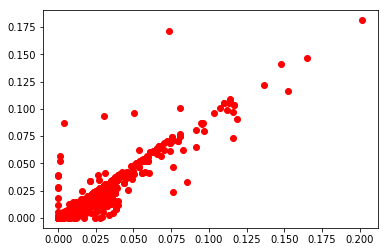

In [16]:
plt.plot(m1,m2,'ro')
ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')

In [17]:

enrichment_factor_1 = 1.5
enrichment_factor_2 = 1.75
enrichment_factor_3 = 2.0
FDR_orphan_threshold = 0.02
# # typical FDR threshold commented
# # as per Rao14 paper, 0.04 was used
# # for primary 10 kb calls:
FDR_orphan_threshold = 0.04
######################################################################
# # Temporarily remove orphans filtering, until q-vals are calculated:
######################################################################
# enrichment_fdr_comply = 
c1 =     (centroids["obs.raw"] > enrichment_factor_2 * centroids["la_exp.lowleft.value"])
c2 =     (centroids["obs.raw"] > enrichment_factor_2 * centroids["la_exp.donut.value"])
c3 =     (centroids["obs.raw"] > enrichment_factor_1 * centroids["la_exp.vertical.value"])
c4 =     (centroids["obs.raw"] > enrichment_factor_1 * centroids["la_exp.horizontal.value"])
c5 =     ( (centroids["obs.raw"] > enrichment_factor_3 * centroids["la_exp.lowleft.value"])| (centroids["obs.raw"] > enrichment_factor_3 * centroids["la_exp.donut.value"]) )
c6 =    ( (centroids["c_size"] > 1) | ((centroids["la_exp.lowleft.qval"]
           + centroids["la_exp.donut.qval"]
           + centroids["la_exp.vertical.qval"]
           + centroids["la_exp.horizontal.qval"]) <= FDR_orphan_threshold) )

cond = pd.DataFrame({'c1':c1,'c2':c2,'c3':c3,'c4':c4,'c5':c5,'c6':c6})

filtered_centr = centroids[c1&c2&c3&c4&c5]
(c1&c2&c3&c4).sum()
# enrichment_fdr_comply.all()

NameError: name 'centroids' is not defined

In [18]:
rr = centroids[c1&c2&c3&c4&c5&(~c6)&(centroids["c_size"] ==1)][["la_exp.lowleft.qval","la_exp.donut.qval","la_exp.vertical.qval","la_exp.horizontal.qval","c_size"]]#.idxmax(axis=1).value_counts()
# plt.imshow(rr,aspect=0.01)
# rr

NameError: name 'centroids' is not defined

In [19]:
# cond['c_size'] = centroids['c_size']
display(cond.sum())

display(cond[centroids['c_size']>1].sum())


NameError: name 'cond' is not defined

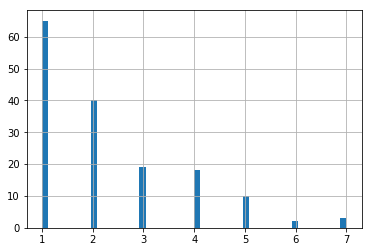

In [20]:
dnm1['c_size'].hist(bins=50)

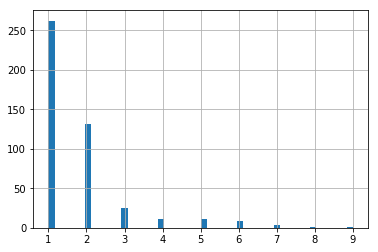

In [21]:
dnm2['c_size'].hist(bins=50)

157


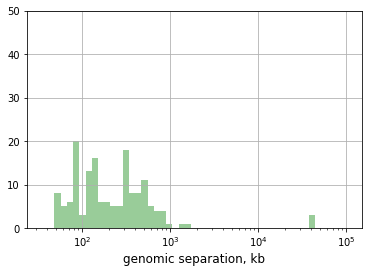

In [22]:

bins = np.geomspace(35000/1000,100000000/1000,num=50)

def diag_hist(df,subidx,color='blue',alpha=0.4,ylim=50):
    d = df.loc[subidx]
    print(len(d))
    (d['diag']/1000).hist(bins=bins,log=False,color=color,alpha=alpha)
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_xlabel("genomic separation, kb",fontsize=12)
    ax.set_ylim(0,ylim)
    
diag_hist(d1f,nm1all,'green')

455


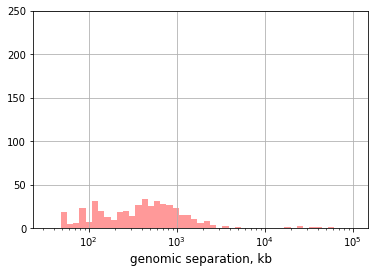

In [23]:
diag_hist(d2f,nm2all,'red',ylim=250)


7599
7599


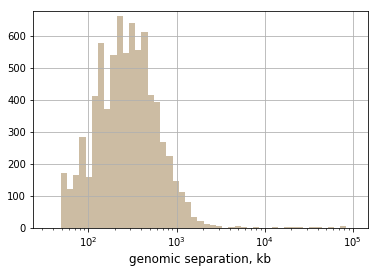

In [24]:
diag_hist(d2f,m2all,'red',alpha=0.2,ylim=680)
diag_hist(d2f,m2all,'green',alpha=0.2,ylim=680)

In [25]:
display(dnm1['diag'].value_counts().head())
display(dnm2['diag'].value_counts().head())

90000     11
120000    10
80000      9
50000      8
150000     7
Name: diag, dtype: int64

110000    20
90000     19
50000     18
120000    11
580000     9
Name: diag, dtype: int64

Index(['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'cstart1',
       'cstart2', 'c_label', 'c_size', 'obs.raw', 'exp.raw',
       'la_exp.donut.value', 'la_exp.vertical.value',
       'la_exp.horizontal.value', 'la_exp.lowleft.value',
       'factor_balance.lowleft.KerObs', 'la_exp.donut.qval',
       'la_exp.vertical.qval', 'la_exp.horizontal.qval', 'la_exp.lowleft.qval',
       'la_exp.donut.nnans', 'la_exp.vertical.nnans',
       'la_exp.horizontal.nnans', 'la_exp.lowleft.nnans', 'diag'],
      dtype='object')

19

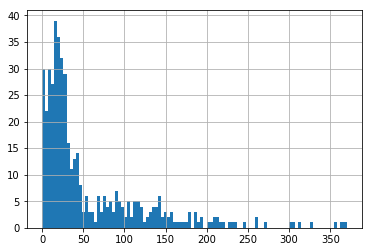

In [26]:
display(dnm1.columns)
# dnm1['factor_balance.lowleft.KerObs'].hist()
# dnm1['la_exp.lowleft.value'].hist()
# dnm1['obs.raw'].hist()
dnm2['la_exp.horizontal.value'].hist(bins=100)
# ax = plt.gca()
# ax.set_xscale('log')
(dnm2['la_exp.horizontal.value']<1.3).sum()

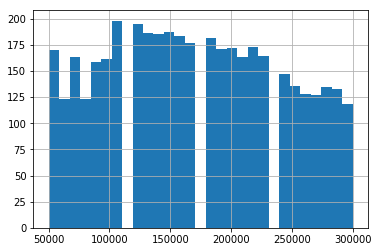

In [27]:
mrg['diag'].hist(bins=np.linspace(50000,300000,30))

In [28]:
# la_exp.lowleft.value
# la_exp.donut.value
# la_exp.vertical.value
mrg['ll_dev'] = np.abs(mrg['la_exp.donut.value_x']/mrg['la_exp.donut.value_y'] - 1.0)

mrg['qq_dev'] = np.abs(np.log(mrg['la_exp.donut.qval_y'])/np.log(mrg['la_exp.donut.qval_x']) - 1.0)

vvv = mrg.sort_values(by='ll_dev')
qqq = mrg.sort_values(by='qq_dev')



In [29]:
d1f[d1f['diag']==50000]['la_exp.lowleft.nnans'].value_counts()

3    179
Name: la_exp.lowleft.nnans, dtype: int64

In [30]:
mrg[mrg['diag']==60000]['la_exp.lowleft.nnans'].value_counts()

1    123
Name: la_exp.lowleft.nnans, dtype: int64

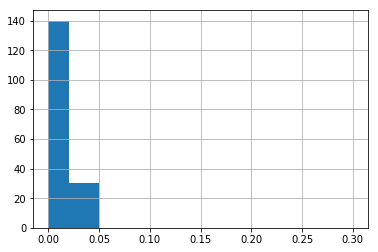

In [31]:
mrg[mrg['diag']==50000]['ll_dev'].hist(bins=[0,0.02,0.05,0.1,0.15,0.2,0.25,0.3])

In [32]:
# plt.plot(mrg['dist'],mrg['la_exp.lowleft.nnans'],'ro')
# ax = plt.gca()
# ax.set_xlim((60000,120000))

# low=-0.01
# up = 0.01
# print((mrg['ll_dev']<=low).sum())
# print((mrg['ll_dev']>=up).sum())
# mrg[mrg['ll_dev']<=low][['la_exp.donut.nnans','la_exp.lowleft.nnans','la_exp.horizontal.nnans']].head(100)
# display(mrg[mrg['ll_dev']<=low]['la_exp.lowleft.nnans'].value_counts())
# display(mrg[mrg['ll_dev']>=up]['la_exp.lowleft.nnans'].value_counts())
# (mrg[mrg['ll_dev']<=low]['dist']/1000.0).hist(bins=bins)
# (mrg[mrg['ll_dev']>=up]['dist']/1000.0).hist(bins=bins)
# # mrg[mrg['ll_dev']>=up]['dist'].hist()
# (mrg[mrg['ll_dev']>=up]['dist']/1000.0).hist(bins=bins)


cls = ['chrom1', 'start1', 'end1', 'weight1', 'chrom2', 'start2', 'end2',
       'weight2', 'la_exp.donut.value', 'la_exp.donut.nnans',
       'la_exp.vertical.value', 'la_exp.vertical.nnans',
       'la_exp.horizontal.value', 'la_exp.horizontal.nnans',
       'factor_balance.lowleft.KerObs', 'la_exp.lowleft.value',
       'la_exp.lowleft.nnans', 'exp.raw', 'obs.raw', 'la_exp.donut.qval',
       'la_exp.vertical.qval', 'la_exp.horizontal.qval', 'la_exp.lowleft.qval',
       'diag']


cls = ['chrom1', 'start1',
#        'end1',
#        'weight1',
#        'chrom2',
#        'start2',
#        'end2',
#        'weight2',
       'diag',
       'exp.raw', 'obs.raw_x',
       'la_exp.donut.value_x',
       'la_exp.donut.value_y',
       'la_exp.donut.qval_x',
       'la_exp.donut.qval_y',
       'la_exp.donut.nnans',
#        'la_exp.vertical.value_x', 'la_exp.vertical.nnans',
#        'la_exp.horizontal.value_x', 'la_exp.horizontal.nnans',
       'factor_balance.lowleft.KerObs',
       'la_exp.lowleft.value_x',
       'la_exp.lowleft.value_y',
       'la_exp.lowleft.qval_x',
       'la_exp.lowleft.qval_y',
       'la_exp.lowleft.nnans',
#        'la_exp.vertical.qval_x',
#        'la_exp.horizontal.qval_x',
#        'obs.raw_y',
#        'la_exp.donut.value_y',
#        'la_exp.horizontal.value_y',
#        'la_exp.vertical.value_y',
#        'la_exp.horizontal.qval_y',
#        'la_exp.vertical.qval_y',
#        'c_size', 'cstart1', 'cstart2', 'radius',
       'll_dev','qq_dev']

# qqq[qqq['la_exp.donut.qval_y']>0.01][cls].tail(40)
qqq[cls].tail(40)

,chrom1,start1,diag,exp.raw,obs.raw_x,la_exp.donut.value_x,la_exp.donut.value_y,la_exp.donut.qval_x,la_exp.donut.qval_y,la_exp.donut.nnans,factor_balance.lowleft.KerObs,la_exp.lowleft.value_x,la_exp.lowleft.value_y,la_exp.lowleft.qval_x,la_exp.lowleft.qval_y,la_exp.lowleft.nnans,ll_dev,qq_dev
3194,chr19,3320000,110000,94.824810,357,154.255970,149.2490,1.075768e-20,7.810855e-38,0,5030.16260,138.619960,129.8790,9.368305e-38,8.135256e-38,0,0.033548,0.858312
4278,chr22,42220000,110000,152.387760,448,197.751630,191.9220,1.020546e-25,3.088423e-47,0,5563.90230,232.417790,219.1770,7.986953e-26,6.660393e-26,0,0.030375,0.861068
3007,chr17,78840000,100000,114.523600,282,123.567170,121.1430,5.164498e-16,2.092718e-29,0,1958.11950,128.059420,123.3050,4.882892e-16,4.467243e-16,0,0.020011,0.876061
4825,chr4,5400000,410000,17.901352,77,30.959265,30.9011,7.509249e-05,1.663402e-08,0,421.99844,29.133127,28.7306,2.115355e-08,1.534138e-08,0,0.001882,0.886092
2001,chr13,78070000,250000,40.126130,115,49.066032,48.8072,1.242423e-06,5.756337e-12,0,701.86260,59.476543,58.4144,1.269237e-06,1.222781e-06,0,0.005303,0.903211
7088,chr9,114850000,700000,16.841244,93,39.532787,38.5540,1.862275e-05,9.590115e-10,0,469.11040,42.855045,41.8189,1.814008e-05,1.710667e-05,0,0.025387,0.906609
2909,chr17,48860000,50000,240.736390,544,245.320340,237.5200,8.463717e-28,7.119874e-53,3,1067.02890,244.351030,226.2580,6.763398e-28,5.445726e-53,3,0.032841,0.926222
2955,chr17,65380000,90000,119.823750,341,158.174070,152.7410,5.357035e-17,1.502034e-32,0,3440.81980,171.145680,161.0870,4.634347e-17,4.115298e-17,0,0.035570,0.955822
2738,chr17,1620000,110000,84.643160,270,123.546020,120.2420,2.775958e-13,1.820984e-25,0,4613.41550,115.579880,110.1470,2.087548e-25,1.985004e-25,0,0.027478,0.970256
1485,chr12,6090000,50000,117.233100,270,122.275320,121.4720,2.775958e-13,1.820984e-25,3,815.93164,122.414720,120.2730,2.585393e-13,1.985004e-25,3,0.006613,0.970256


In [33]:
# qqq[qqq['la_exp.donut.qval_y']>0.01][cls].tail(40)
# qqq[(qqq['la_exp.donut.value_x']>50)&(qqq['la_exp.donut.value_x']<65)].sort_values(by='obs.raw_x')[cls]
qqq[(qqq['obs.raw_y']==115)&(qqq['la_exp.donut.value_x']>50)&(qqq['la_exp.donut.value_x']<65)][cls]

,chrom1,start1,diag,exp.raw,obs.raw_x,la_exp.donut.value_x,la_exp.donut.value_y,la_exp.donut.qval_x,la_exp.donut.qval_y,la_exp.donut.nnans,factor_balance.lowleft.KerObs,la_exp.lowleft.value_x,la_exp.lowleft.value_y,la_exp.lowleft.qval_x,la_exp.lowleft.qval_y,la_exp.lowleft.nnans,ll_dev,qq_dev
3137,chr18,56810000,210000,52.293617,115,56.480950,56.0961,0.000001,0.000001,0,637.57855,51.385815,50.5219,1.269237e-06,1.222781e-06,0,0.006861,0.007020
5925,chr6,105930000,740000,14.513107,115,56.227837,56.3314,0.000001,0.000001,0,469.90753,40.451897,40.4455,7.555347e-12,6.696449e-12,0,0.001838,0.007020
1915,chr13,33770000,520000,25.845276,115,51.524450,51.5364,0.000001,0.000001,0,462.49677,54.495390,53.8504,1.269237e-06,1.222781e-06,0,0.000232,0.007020
4611,chr3,126460000,710000,16.588839,115,58.909450,59.1959,0.000001,0.000001,0,537.27230,51.094822,51.3593,1.269237e-06,1.222781e-06,0,0.004839,0.007020
2273,chr14,100440000,210000,34.719044,115,50.262794,49.8369,0.000001,0.000001,0,1220.83540,54.778507,54.5106,1.269237e-06,1.222781e-06,0,0.008546,0.007020
355,chr1,115520000,70000,63.336273,115,55.550327,54.9865,0.000001,0.000001,0,890.84940,51.943745,50.9487,1.269237e-06,1.222781e-06,0,0.010254,0.007020
6089,chr6,156880000,200000,42.268040,115,53.566963,53.7046,0.000001,0.000001,0,1027.47840,57.536220,57.3224,1.269237e-06,1.222781e-06,0,0.002563,0.007020
110,chr1,28970000,230000,48.878815,115,50.954666,50.8823,0.000001,0.000001,0,923.96106,59.493385,59.4723,1.269237e-06,1.222781e-06,0,0.001422,0.007020
5768,chr6,35990000,330000,38.640060,115,57.367474,57.1978,0.000001,0.000001,0,628.53015,55.312540,55.0020,1.269237e-06,1.222781e-06,0,0.002966,0.007020
6651,chr8,62150000,220000,34.431230,115,54.295853,54.5323,0.000001,0.000001,0,918.19720,51.384403,51.1375,1.269237e-06,1.222781e-06,0,0.004336,0.007020


In [34]:
h2d = pd.read_table("diag_rao4mb10kb.KR.fixed.donut.hist.txt")

# pd.cut(scored_df["la_exp."+k+".value"],ledges)
nlchunks = 46
base = 2**(1/3.0)
base = 2**(0.33)
ledges = np.concatenate(([-np.inf,],
                        np.logspace(0,
                                    nlchunks-1,
                                    num=nlchunks,
                                    base=base,
                                    dtype=np.float),
                        [np.inf,]))


from scipy.stats import poisson
fdr = 0.1
# generate a reverse cumulative histogram for each kernel,
#  such that 0th raw contains total # of pixels in each lambda-chunk:
rcs_hist = h2d.iloc[::-1].cumsum(axis=0).iloc[::-1]
# now for every kernel-type k - create rcsPoisson,
# a unit Poisson distribution for every lambda-chunk
# using upper boundary of each lambda-chunk as the expected:
rcs_Poisson = pd.DataFrame()
for mu, column in zip(ledges[1:-1], h2d.columns):
    # poisson.sf = 1 - poisson.cdf, but more precise
    # poisson.sf(-1,mu) == 1.0, i.e. is equivalent to the
    # poisson.pmf(gw_hist[k].index,mu)[::-1].cumsum()[::-1]
    # i.e., the way unitPoissonPMF is generated in HiCCUPS:
    renorm_factors = rcs_hist.loc[0,column]
    rcs_Poisson[column] = renorm_factors * poisson.sf(h2d.index-1, mu)
# once we have both RCS hist and the Poisson:
# now compare rcs_hist and re-normalized rcs_Poisson
# to infer FDR thresolds for every lambda-chunk:
fdr_diff = fdr * rcs_hist - rcs_Poisson
# determine the threshold by checking the value at which
# 'fdr_diff' first turns positive:
threshold_df = fdr_diff.where(fdr_diff>0).apply(lambda col: col.first_valid_index())
# q-values ...
# roughly speaking, qvalues[k] =  rcs_Poisson[k]/rcs_hist[k]
# bear in mind some issues with lots of NaNs and Infs after
# such a brave operation ...
qvalues = rcs_Poisson / rcs_hist
# fill NaNs with the "unreachably" high value:
very_high_value = len(rcs_hist)
threshold_df = threshold_df.fillna(very_high_value).astype(np.integer)

In [35]:
print(qvalues.iloc[110:115,17])
print(qvalues.iloc[110:115,18])

110    6.333187e-12
111    2.905985e-12
112    1.317770e-12
113    5.929885e-13
114    2.663516e-13
Name: (48.84, 61.393], dtype: float64
110    5.543445e-07
111    3.213737e-07
112    1.847877e-07
113    1.051489e-07
114    5.912573e-08
Name: (61.393, 77.172], dtype: float64


In [36]:
get_bin = lambda v: np.floor(np.log(v)/np.log(2**0.33))

print(get_bin(1.580082))

h2d.columns[0]


1.0


'(-inf, 1.257]'

In [37]:
pd.cut(qqq[qqq['la_exp.donut.qval_y']>0.01][cls].tail(40)["la_exp.donut.value_x"],ledges,retbins=False) == pd.cut(qqq[qqq['la_exp.donut.qval_y']>0.01][cls].tail(400)["la_exp.donut.value_y"],ledges,retbins=False)

2708     True
6997     True
3669     True
7189     True
3870     True
2181     True
1053     True
2879     True
6778     True
5144     True
4405     True
5486     True
5259     True
617      True
4101     True
3762     True
5130     True
4503     True
3405     True
4214     True
3390     True
7041    False
Name: la_exp.donut.value_y, dtype: bool

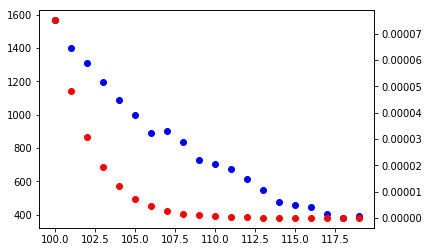

In [38]:
_1,_2 = 7, 374
_1,_2 = 100, 120
plt.plot(h2d.iloc[_1:_2,18],'bo')
ax = plt.gca()
axt = ax.twinx()
axt.plot(qvalues.iloc[_1:_2,18],'ro')
# np.argmax(h2d.iloc[::-1,18]>0)

/home/venevs/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


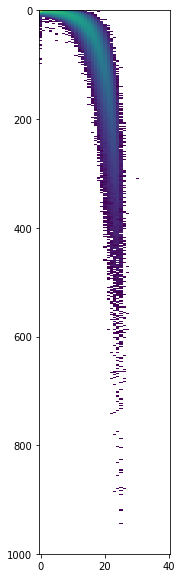

In [39]:
h2d = pd.read_table("diag_rao4mb10kb.KR.fixed.horizontal.hist.txt")
plt.figure(figsize=(10,10))
plt.imshow(np.log(h2d.values[:1000,:41]),aspect=0.17)

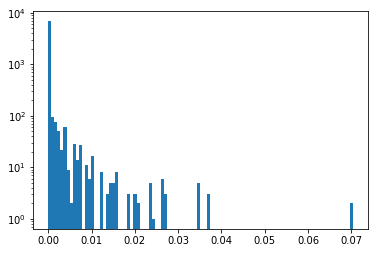

In [40]:
x = plt.hist(mrg['la_exp.lowleft.qval_y'],bins=100,log=True)

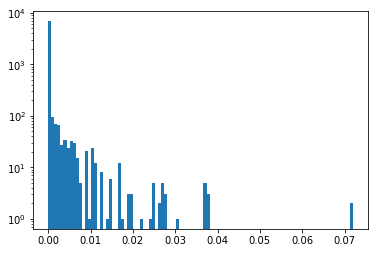

In [41]:
y = plt.hist(mrg['la_exp.lowleft.qval_x'],bins=100,log=True)

(0, 0.1)

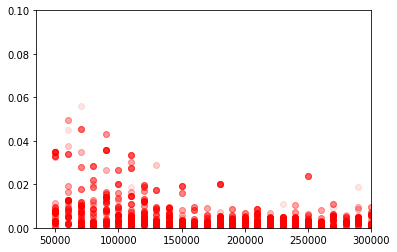

In [42]:

# plt.plot(np.arange(len(vvv)),vvv['ll_dev'],'ro-',alpha=0.1)
plt.plot(vvv['diag'],vvv['ll_dev'],'ro',alpha=0.1)
ax = plt.gca()
ax.set_xlim((35000,300000))
ax.set_ylim((0,0.1))



In [43]:
tt = pd.cut(mrg['la_exp.donut.value_x'],ledges).apply(lambda _:float(_.right)).astype(np.ndarray)
# tt.astype(np.ndarray)
# mrg

In [44]:
mrg['la_exp.donut.value_x'].argmin()

/home/venevs/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  """Entry point for launching an IPython kernel.


6284

In [45]:
# pd.cut(mrg['la_exp.donut.value_x'],ledges,right=False,include_lowest=False)[6281:6290]
# pd.cut?

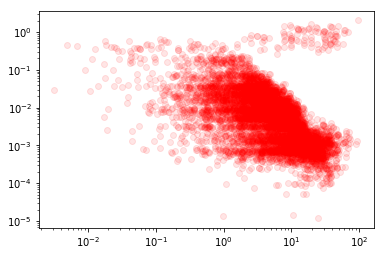

In [46]:
x = (mrg['la_exp.donut.value_x'] - pd.cut(mrg['la_exp.donut.value_x'],ledges).apply(lambda _:float(_.right)).astype(np.ndarray)).abs()
plt.plot(x,mrg['qq_dev'],'ro',alpha=0.1)
ax = plt.gca()
# ax.set_xlim((35000,300000))
# ax.set_ylim((0,20.1))
ax.set_xscale('log')
ax.set_yscale('log')


# mrg[(x>10)&(mrg['qq_dev']>0.1)][cls]

In [47]:
xx = pd.cut(qqq["la_exp.donut.value_x"],ledges,retbins=False).iloc[0]

xx.right

pd.cut(qqq["la_exp.donut.value_x"],ledges,retbins=False).apply(lambda x:float(x.left)).values

[121.938, 121.938, 121.938, 153.277, 153.277, ..., 30.910, 192.672, 38.854, 77.172, 382.681]
Length: 7389
Categories (47, float64): [-inf < 1.000000 < 1.257000 < 1.580000 ... 14868.794 < 18690.273 < 23493.923 < 29532.175]

(0, 2)

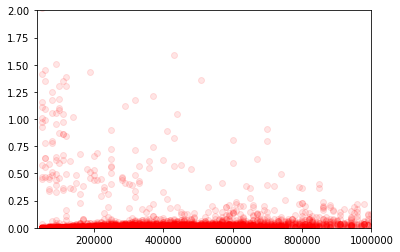

In [48]:

# plt.plot(np.arange(len(vvv)),vvv['ll_dev'],'ro-',alpha=0.1)
plt.plot(qqq['diag'],qqq['qq_dev'],'ro',alpha=0.1)
ax = plt.gca()
ax.set_xlim((35000,1000000))
ax.set_ylim((0,2))


In [49]:
bins=np.linspace(45000/1000.,500000/1000.,40)

In [50]:

vvv['ll_dev'].head()
qqq['qq_dev'].head()

# vvv.head(300)['factor_balance.lowleft.KerObs'].hist()
# 
# (vvv.tail(500)['la_exp.lowleft.nnans']).hist(bins=40,alpha=0.6,log=False)
# (vvv.tail(1100)['dist']/1000.).hist(bins=bins,alpha=0.6)

# vvv.iloc[3000:5000]['dist'].hist()

517     0.000012
2711    0.000013
78      0.000015
2867    0.000052
204     0.000053
Name: qq_dev, dtype: float64

In [51]:
# vvv.head(1000)['factor_balance.lowleft.KerObs'].hist()
# (vvv.head(6000)['dist']/1000.).hist(bins=bins,alpha=0.6)
# (vvv.head(6000)['la_exp.lowleft.nnans']).hist(bins=40,alpha=0.6,log=True)

In [52]:
mrg[mrg['diag']==50000].head()

,chrom1,start1,end1,chrom2,start2,end2,cstart1_x,cstart2_x,c_label,c_size_x,...,la_exp.lowleft.qval_y,la_exp.donut.qval_y,la_exp.horizontal.qval_y,la_exp.vertical.qval_y,c_size_y,cstart1_y,cstart2_y,radius,ll_dev,qq_dev
37,chr1,11720000,11730000,chr1,11770000,11780000,1.171400e+07,1.177800e+07,72,5,...,9.439493e-23,1.853549e-09,2.461025e-09,2.379317e-09,7,11717857,11783571,15452.362609,0.007347,0.002797
38,chr1,11900000,11910000,chr1,11950000,11960000,1.189800e+07,1.195600e+07,73,5,...,1.153525e-41,1.247357e-41,1.995804e-41,1.014711e-21,5,11903000,11961000,12649.110641,0.007348,0.000525
74,chr1,23810000,23820000,chr1,23860000,23870000,2.381500e+07,2.386500e+07,150,2,...,4.153078e-29,4.163349e-29,6.784600e-29,1.654726e-14,2,23820000,23870000,7071.067812,0.007350,0.000777
77,chr1,24020000,24030000,chr1,24070000,24080000,2.401800e+07,2.407600e+07,153,5,...,1.031020e-24,1.473540e-24,2.029443e-24,1.878918e-24,5,24023000,24081000,12649.110641,0.007346,0.001098
93,chr1,26420000,26430000,chr1,26470000,26480000,2.642333e+07,2.647667e+07,181,3,...,6.085312e-37,6.569879e-37,1.040244e-36,1.728699e-18,3,26428333,26481666,7453.559925,0.007348,0.000627


In [53]:
mrg.columns

Index(['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'cstart1_x',
       'cstart2_x', 'c_label', 'c_size_x', 'obs.raw_x', 'exp.raw',
       'la_exp.donut.value_x', 'la_exp.vertical.value_x',
       'la_exp.horizontal.value_x', 'la_exp.lowleft.value_x',
       'factor_balance.lowleft.KerObs', 'la_exp.donut.qval_x',
       'la_exp.vertical.qval_x', 'la_exp.horizontal.qval_x',
       'la_exp.lowleft.qval_x', 'la_exp.donut.nnans', 'la_exp.vertical.nnans',
       'la_exp.horizontal.nnans', 'la_exp.lowleft.nnans', 'diag', 'color',
       'obs.raw_y', 'la_exp.lowleft.value_y', 'la_exp.donut.value_y',
       'la_exp.horizontal.value_y', 'la_exp.vertical.value_y',
       'la_exp.lowleft.qval_y', 'la_exp.donut.qval_y',
       'la_exp.horizontal.qval_y', 'la_exp.vertical.qval_y', 'c_size_y',
       'cstart1_y', 'cstart2_y', 'radius', 'll_dev', 'qq_dev'],
      dtype='object')

In [54]:
# plt.plot(mrg['c_size_x'],mrg['c_size_y'],'ro',alpha=0.1)

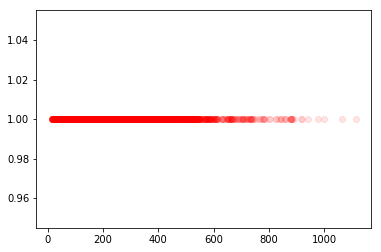

In [55]:
plt.plot(mrg['obs.raw_x'],mrg['obs.raw_y']/mrg['obs.raw_x'],'ro',alpha=0.1)

(1e-40, 1)

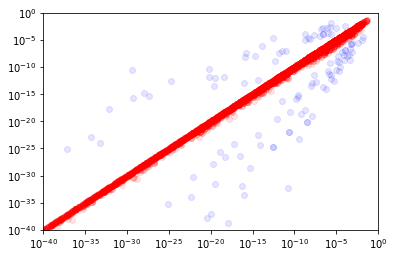

In [56]:

mmmm1 = pd.cut(mrg['la_exp.donut.value_x'],ledges,right=False) == pd.cut(mrg['la_exp.donut.value_y'],ledges,right=False)
mmmm2 = pd.cut(mrg['la_exp.donut.value_x'],ledges,right=True) == pd.cut(mrg['la_exp.donut.value_y'],ledges,right=True)
mmmm = mmmm1
# mmmm = mrg['ll_dev'] <= 0.029

plt.plot(mrg[mmmm]['la_exp.donut.qval_x'],mrg[mmmm]['la_exp.donut.qval_y'],'ro',alpha=0.1)
plt.plot(mrg[~mmmm]['la_exp.donut.qval_x'],mrg[~mmmm]['la_exp.donut.qval_y'],'bo',alpha=0.1)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-40,1)
ax.set_ylim(1e-40,1)
# ax.set_yscale('log')



(1e-40, 1)

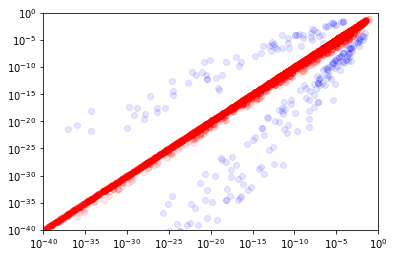

In [57]:

mmmm = pd.cut(mrg['la_exp.lowleft.value_x'],ledges) == pd.cut(mrg['la_exp.lowleft.value_y'],ledges)

plt.plot(mrg[mmmm]['la_exp.lowleft.qval_x'],mrg[mmmm]['la_exp.lowleft.qval_y'],'ro',alpha=0.1)
plt.plot(mrg[~mmmm]['la_exp.lowleft.qval_x'],mrg[~mmmm]['la_exp.lowleft.qval_y'],'bo',alpha=0.1)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-40,1)
ax.set_ylim(1e-40,1)
# ax.set_yscale('log')


(1e-40, 1)

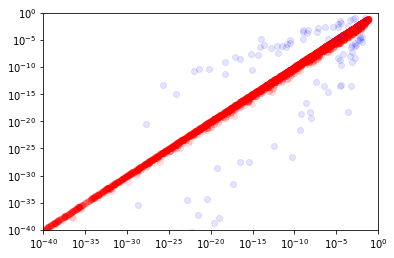

In [58]:
mmmm = pd.cut(mrg['la_exp.vertical.value_x'],ledges) == pd.cut(mrg['la_exp.vertical.value_y'],ledges)

plt.plot(mrg[mmmm]['la_exp.vertical.qval_x'],mrg[mmmm]['la_exp.vertical.qval_y'],'ro',alpha=0.1)
plt.plot(mrg[~mmmm]['la_exp.vertical.qval_x'],mrg[~mmmm]['la_exp.vertical.qval_y'],'bo',alpha=0.1)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-40,1)
ax.set_ylim(1e-40,1)
# ax.set_yscale('log')



(1e-40, 1)

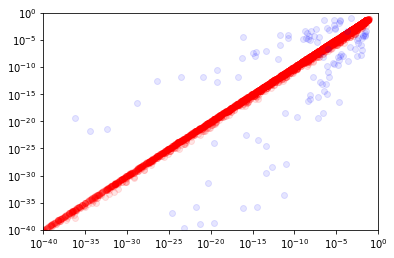

In [59]:
mmmm = pd.cut(mrg['la_exp.horizontal.value_x'],ledges) == pd.cut(mrg['la_exp.horizontal.value_y'],ledges)

plt.plot(mrg[mmmm]['la_exp.horizontal.qval_x'],mrg[mmmm]['la_exp.horizontal.qval_y'],'ro',alpha=0.1)
plt.plot(mrg[~mmmm]['la_exp.horizontal.qval_x'],mrg[~mmmm]['la_exp.horizontal.qval_y'],'bo',alpha=0.1)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-40,1)
ax.set_ylim(1e-40,1)
# ax.set_yscale('log')


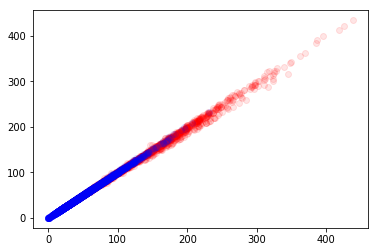

In [60]:
mmmm1 = pd.cut(mrg['la_exp.lowleft.value_x'],ledges,right=False) == pd.cut(mrg['la_exp.lowleft.value_y'],ledges,right=False)
mmmm2 = pd.cut(mrg['la_exp.lowleft.value_x'],ledges,right=True) == pd.cut(mrg['la_exp.lowleft.value_y'],ledges,right=True)
mmmm = mrg['diag']<210000
# mmmm = mrg['c_size_y'] == 1



plt.plot(mrg[mmmm]['la_exp.lowleft.value_x'],mrg[mmmm]['la_exp.lowleft.value_y'],'ro',alpha=0.1)
plt.plot(mrg[~mmmm]['la_exp.lowleft.value_x'],mrg[~mmmm]['la_exp.lowleft.value_y'],'bo',alpha=0.1)
ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')

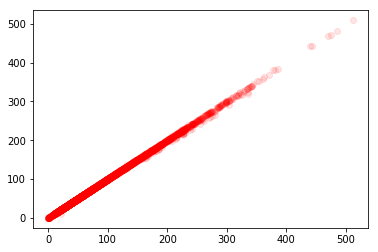

In [61]:
plt.plot(mrg['la_exp.vertical.value_x'],mrg['la_exp.vertical.value_y'],'ro',alpha=0.1)

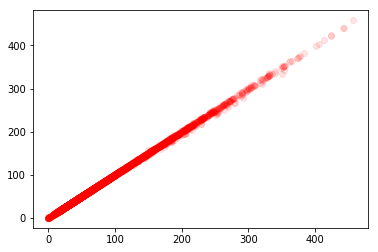

In [62]:
plt.plot(mrg['la_exp.horizontal.value_x'],mrg['la_exp.horizontal.value_y'],'ro',alpha=0.1)

In [63]:
################################################
## you enter area of lost knowledge ...
################################################

In [64]:
t1 = cKDTree(d1c[['start1','start2']].values)
t2 = cKDTree(d2c[['start1','start2']].values)
# d1c.head()

In [116]:
d2.shape

(8054, 6)

In [113]:
x = np.asarray([len(l) for l in t2.query_ball_tree(t1,r=15000)])
(x>0).sum()

199

In [126]:
neighs = []
for chrom in d1["chrom1"].unique():
    # chrom="1"
    d1c = d1[d1['chrom1']==chrom]
    d2c = d2[d2['chrom1']=="chr"+chrom]
    t1 = cKDTree(d1c[['start1','start2']].values)
    t2 = cKDTree(d2c[['start1','start2']].values)
    res = t2.query_ball_tree(t1,20000)
    x = np.asarray([len(l) for l in res])
    sss = (x>0).sum()
    print("chr"+chrom+" "+str(sss))
    neighs.append(sss)

print("Total number of final Rao loops that\n\
   can be found in our pre-clustered list: {}\n\
   and that's out of {} loops reported by Rao".format(sum(neighs),d2.shape[0]))

chr1 720
chr2 584
chr3 535
chr4 408
chr5 442
chr6 512
chr7 381
chr8 416
chr9 311
chr10 350
chr11 410
chr12 404
chr13 199
chr14 266
chr15 241
chr16 206
chr17 287
chr18 173
chr19 178
chr20 200
chr21 78
chr22 135
chrX 219
Total number of final Rao loops that
   can be found in our pre-clustered list: 7655
   and that's out of 8054 loops reported by Rao


In [127]:
neighs = []
for chrom in d1["chrom1"].unique():
    # chrom="1"
    d1c = d1[d1['chrom1']==chrom]
    d2c = d2[d2['chrom1']=="chr"+chrom]
    t1 = cKDTree(d1c[['start1','start2']].values)
    t2 = cKDTree(d2c[['start1','start2']].values)
    res = t1.query_ball_tree(t2,20000)
    x = np.asarray([len(l) for l in res])
    sss = (x>0).sum()
    print("chr"+chrom+" "+str(sss))
    neighs.append(sss)

print("Total number of final Rao loops that\n\
   can be found in our pre-clustered list: {}\n\
   and that's out of {} loops reported by Rao".format(sum(neighs),d2.shape[0]))

chr1 2772
chr2 2114
chr3 1987
chr4 1339
chr5 1550
chr6 1793
chr7 1389
chr8 1453
chr9 1183
chr10 1209
chr11 1628
chr12 1482
chr13 627
chr14 961
chr15 914
chr16 811
chr17 1191
chr18 598
chr19 692
chr20 815
chr21 296
chr22 574
chrX 648
Total number of final Rao loops that
   can be found in our pre-clustered list: 28026
   and that's out of 8054 loops reported by Rao


In [118]:
sum(neighs)

7655

In [65]:
# (np.asarray([len(r) for r in res])>1).any()
res

[[245],
 [628],
 [169],
 [],
 [],
 [118],
 [],
 [590],
 [],
 [417],
 [505],
 [663],
 [122, 221],
 [122, 221],
 [318],
 [342],
 [494],
 [693],
 [722],
 [],
 [598],
 [382],
 [480],
 [90],
 [331],
 [141],
 [435],
 [46],
 [19],
 [],
 [],
 [315],
 [31],
 [],
 [493],
 [],
 [269],
 [295],
 [],
 [457],
 [520],
 [],
 [95],
 [5],
 [611],
 [512],
 [200],
 [220],
 [135, 282],
 [],
 [29, 319],
 [29, 319],
 [578],
 [],
 [34],
 [98],
 [394],
 [468],
 [],
 [],
 [210],
 [543],
 [458],
 [293],
 [230],
 [296],
 [648],
 [43],
 [],
 [255],
 [298],
 [481],
 [373],
 [333],
 [252],
 [15],
 [4],
 [375],
 [13],
 [438],
 [],
 [73],
 [629],
 [243],
 [205, 351],
 [205, 351],
 [11],
 [],
 [763],
 [603],
 [],
 [349],
 [93],
 [84],
 [407],
 [104],
 [104],
 [430],
 [224],
 [48],
 [336],
 [336],
 [109],
 [91],
 [42],
 [337],
 [501],
 [],
 [],
 [],
 [],
 [],
 [],
 [506],
 [96],
 [502],
 [531],
 [201],
 [306],
 [471],
 [585],
 [],
 [660],
 [],
 [88],
 [16],
 [476],
 [646],
 [],
 [],
 [137],
 [563],
 [],
 [431],
 [],
 [14

In [46]:
sum(neighs)

6489

In [5]:
X = np.asarray([[1,1], [1,2], [1,3], [2,2], [2,1], [3,2], [4,1], [9,9], [8,8], [7,9], [8,9], [4,9]])

In [6]:
ttt = KDTree(X)

In [16]:
ttt.query([1,1],k=2)

(array([0., 1.]), array([0, 1]))

In [19]:
# ls
f1="out_nonoverlap1KR"
f2="out_nonoverlap2KR"

In [21]:
d1=pd.read_table(f1)
d2=pd.read_table(f2)

In [69]:
print(d1.shape)
print(d2.shape)

(1531, 25)
(1304, 26)


In [51]:
(d1['start2'] - d1['start1']).max()

218880000

(50000, 4000000)

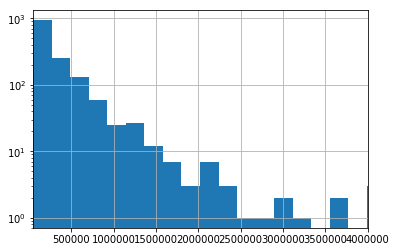

In [60]:
(d1['start2'] - d1['start1']).hist(bins=1000,log=True)
ax = plt.gca()
# ax.set_xscale('log')
ax.set_xlim(50000,4000000)

(50000, 4000000)

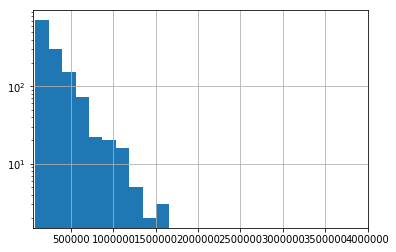

In [61]:
(d2['start2'] - d2['start1']).hist(bins=10,log=True)
ax = plt.gca()
# ax.set_xscale('log')
ax.set_xlim(50000,4000000)

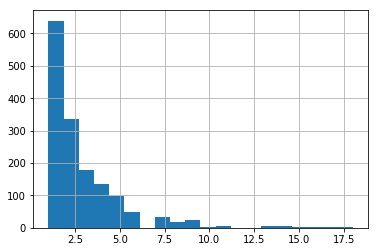

In [67]:
d1['c_size'].hist(bins=20)

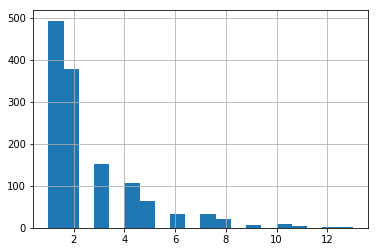

In [68]:
d2['c_size'].hist(bins=20)

In [ ]:
python ../random_tools/compare_dot_lists.py \
    --radius 20000 -v \
    --out-nonoverlap1 out_nonoverlap1_kr \
    --out-nonoverlap2 out_nonoverlap2_kr \
    --out-overlap1 out_overlap1_kr \
    --out-overlap2 out_overlap2_kr \
    Rao2014_GM12878_primary_HiCCUPS_looplist.txt final_cloops4mb.10kb.KR.txt